In [1]:
import numpy as np
import cv2
from PIL import Image
import torch
import pytorch_lightning as pl
import pandas as pd
import os
from copy import deepcopy
import torch.nn.functional as F
from torchmetrics import Metric
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
from torch.utils import data
from torch.nn.utils.rnn import pad_sequence

from src.commons.utils import to_numpy, SegAnyChangeVersion, show_img, show_pair_img, show_prediction_sample, resize
from src.models.commons.mask_process import extract_object_from_batch, binarize_mask
from src.commons.constants import IMG_SIZE
from src.data.process import generate_grid_prompt
from src.commons.utils import create_sample_grid_with_prompt, get_mask_with_prompt, fig2arr

Welcome in JZAY


In [2]:
from src.commons.utils_io import load_sam
from src.models.commons.bisam import BiSam2, SamModeInference
from src.models.commons.model import BiSam

from src.commons.utils import batch_to_list

In [3]:
def show_prompts_on_mask(mask: torch.Tensor, batch, batch_idx: int):
    if mask.shape[-1] != IMG_SIZE[0]:
        mask = resize(mask, IMG_SIZE)
    coord_points = batch["point_coords"][batch_idx]
    mask_pt = get_mask_with_prompt(binarize_mask(mask[batch_idx], th=0) , coord_points)
    show_img(mask_pt)

### Load dloader manually

In [4]:
from src.data.loader import BiTemporalDataset
from src.data.process import DefaultTransform
from omegaconf import OmegaConf

params = {
    "prompt_type": "sample",
    "n_prompt": 1,
    "n_shape":3,
    "loc": "center",
    "batch_size": 2,
}
ds = BiTemporalDataset(
            name="levir-cd",
            dtype="test",
            transform=DefaultTransform(),
            params=OmegaConf.create(params),
        )

In [5]:
dloader = data.DataLoader(
            ds,
            batch_size=params.get('batch_size'),
            shuffle=False,
            num_workers=0,
        )

In [6]:
batch = next(iter(dloader))

/home/rustt/Documents/IGN/data/levir-cd/test/label/test_1.png
/home/rustt/Documents/IGN/data/levir-cd/test/label/test_2.png


### Load model

In [8]:
bisam2 = load_sam(
    model_type="vit_b", model_cls=BiSam2, version= "dev2", device="cpu"
)

2024-07-20 07:53:02,723 - INFO ::  build vit_b BiSam2


In [9]:
bisam = load_sam(
    model_type="vit_b", model_cls=BiSam, version= "dev", device="cpu"
)

2024-07-20 07:53:04,496 - INFO ::  build vit_b BiSam


### change model : many prompt to one mask :

In [10]:
from src.commons.utils_io import load_config
import hydra
from hydra.core.global_hydra import GlobalHydra

In [13]:
GlobalHydra.instance().clear()
list_args=["experiment=mp_naive", "sam_type=small", "data=levir-cd", "data.params.n_shape=3", "data.params.num_worker=0"]
cfg = load_config(list_args)

In [14]:
module = hydra.utils.instantiate(cfg.model.instance)

In [15]:
cfg.data.params.num_worker

0

In [ ]:
# data_module = hydra.utils.instantiate(cfg.data)

# data_module.params

# data_module.setup("fit")
# train_dloader = data_module.train_dataloader()

# batch = next(iter(train_dloader))

### Modif mask decoder

In [16]:
out = bisam2(batch, multimask_output=False)
preds2 = out["masks"] > 0
print(preds2.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([2, 1, 1, 256, 256])


In [17]:
out = bisam(batch, multimask_output=False, mode=SamModeInference.INTERACTIVE)
preds = out["masks"] > 0
print(preds.shape)

sparse_embeddings: torch.Size([2, 3, 2, 256])
dense_embeddings: torch.Size([2, 3, 256, 64, 64])
torch.Size([2, 3, 1, 256, 256])


In [18]:
point_coords = (
    batch["point_coords"].clone()
)
point_labels = (
    batch["point_labels"].clone()
)

### Prompt encoder

In [20]:
point_coords.shape, point_labels.shape

(torch.Size([2, 3, 2]), torch.Size([2, 3]))

In [28]:
i = 0

#### Bisam2

Un mask pour tous les points

In [54]:
point_coords = batch["point_coords"][i]
# remove padding points
point_labels = batch["point_labels"][i]
# if we add batch dim, why it could not works with batch ?
points = point_coords[None, :, :], point_labels[None, :]

#points = point_coords, point_labels

sparse_embeddings_b2, dense_embeddings_b2 = bisam2.prompt_encoder(
    points=points,
    boxes=None,
    masks=None,
)

In [55]:
print(f"sparse_embeddings: {sparse_embeddings_b2.shape}")
print(f"dense_embeddings: {dense_embeddings_b2.shape}")

sparse_embeddings: torch.Size([1, 4, 256])
dense_embeddings: torch.Size([1, 256, 64, 64])


In [45]:
point_coords = batch["point_coords"][i]
# remove padding points
point_labels = batch["point_labels"][i]
# if we add batch dim, why it could not works with batch ?
points = point_coords[:,None, :], point_labels[:, None]

#points = point_coords, point_labels

sparse_embeddings_b2, dense_embeddings_b2 = bisam2.prompt_encoder(
    points=points,
    boxes=None,
    masks=None,
)

In [46]:
print(f"sparse_embeddings: {sparse_embeddings_b2.shape}")
print(f"dense_embeddings: {dense_embeddings_b2.shape}")

sparse_embeddings: torch.Size([3, 2, 256])
dense_embeddings: torch.Size([3, 256, 64, 64])


#### Bisam

Un masque par point

In [32]:
point_coords = batch["point_coords"]
# remove padding points
point_labels = batch["point_labels"]

sparse_embeddings, dense_embeddings = bisam.prompt_encoder(
    points=(
        point_coords[:, :, None, :],
        point_labels[..., None],
    ),
    boxes=None,
    masks=None,
)

In [33]:
print(f"sparse_embeddings: {sparse_embeddings.shape}")
print(f"dense_embeddings: {dense_embeddings.shape}")

sparse_embeddings: torch.Size([2, 3, 2, 256])
dense_embeddings: torch.Size([2, 3, 256, 64, 64])


Un masque pour tous les points

In [57]:
point_coords = batch["point_coords"]
# remove padding points
point_labels = batch["point_labels"]

sparse_embeddings, dense_embeddings = bisam.prompt_encoder(
    points=(
        point_coords[:,None, :],
        point_labels[:, None,...],
    ), 
    boxes=None,
    masks=None,
)

In [58]:
print(f"sparse_embeddings: {sparse_embeddings.shape}")
print(f"dense_embeddings: {dense_embeddings.shape}")

sparse_embeddings: torch.Size([2, 1, 4, 256])
dense_embeddings: torch.Size([2, 1, 256, 64, 64])


Ok ! Easy

#### Sanity check

In [59]:
torch.equal(sparse_embeddings_b2, sparse_embeddings[i])

True

### Image encoder

In [60]:
image_embeddings = bisam2.image_embeddings

In [61]:
image_embeddings.shape

torch.Size([2, 256, 64, 64])

#### Mask decoder

In [206]:
preds2, iou_predictions =  bisam2.mask_decoder(
    image_embeddings=image_embeddings,  # (B, 256, 64, 64)
    image_pe=bisam2.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
    sparse_prompt_embeddings=sparse_embeddings,  # (B, N, 2, 256)
    dense_prompt_embeddings=dense_embeddings,  # (B, N, 256, 64, 64)
    multimask_output=False,
)

In [73]:
low_res_masks, iou_predictions =  bisam.mask_decoder.predict_masks_batch(
    image_embeddings=image_embeddings,  # (B, 256, 64, 64)
    image_pe=bisam.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
    sparse_prompt_embeddings=sparse_embeddings,  # (B, N, 2, 256)
    dense_prompt_embeddings=dense_embeddings,  # (B, N, 256, 64, 64)
)

preds, iou_predictions = bisam.select_masks(
    low_res_masks, 
    iou_predictions, 
    multimask_output=False
)
preds = bisam.upscale_masks(
    preds,
    IMG_SIZE
)
preds = preds > 0

In [74]:
preds.shape

torch.Size([2, 1, 1, 1024, 1024])

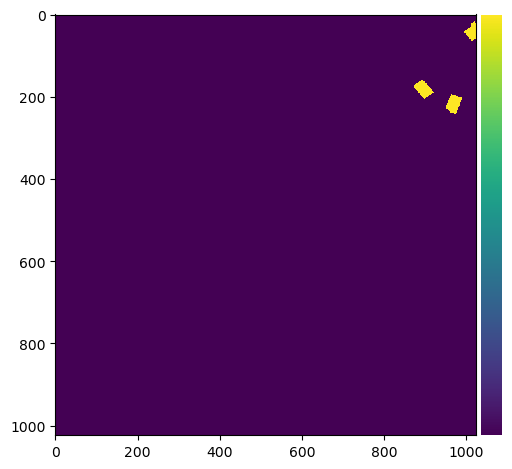

In [76]:
show_img(to_numpy(batch["label"][0], transpose=False))

Un masque pour tous les points

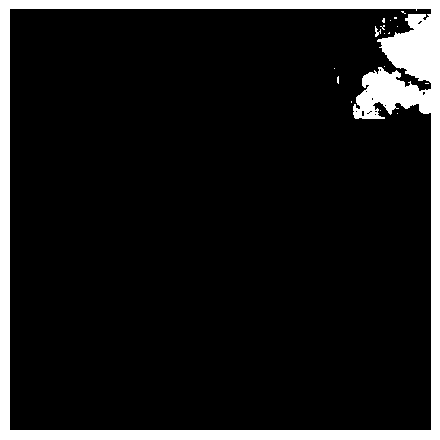

In [98]:
show_img(to_numpy(preds.squeeze()[0], transpose=False))

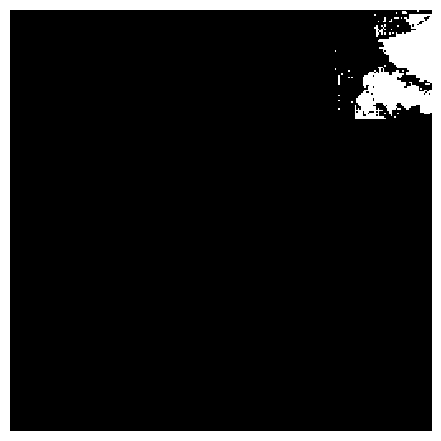

In [77]:
show_img(to_numpy(preds2.squeeze()[0], transpose=False))

Un masque par point

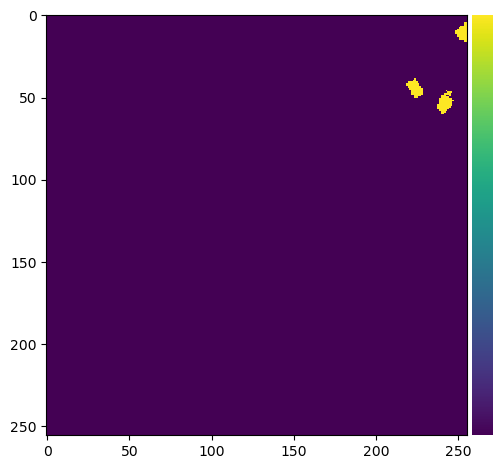

In [25]:
show_img(to_numpy(torch.sum(preds[0].squeeze(), dim=0), transpose=False))